# Data Scientist - Case Study
**Situation:** <br>

Time given: 2 days


Bank XYZ is one of the leading banks in the Philippines that offers fixed term car loans. In order to improve the accuracy of the decision process whether to accept/reject the applicants, the Bank aims to rank the applications based on available information during the origination. To meet this objective, the client commissioned you to act as their analytics consultant to do the following:
1.	**Provide insights on their existing portfolio.**
2.	Develop a model that will predict the borrower’s likelihood default using their internal historical data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import utils

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette("muted")
warnings.filterwarnings("ignore")

CLR = '#597dbf'
PLT = 'Blues'

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
df = pd.read_csv('car_data.txt', sep='\t', index_col=0)

# data.AccountNo.nunique()
df.set_index('AccountNo', inplace=True)
print(df.shape)
df.head()

(20000, 81)


,ApplicationDate,Channel,DealerName,ExistingClient,NoOfExistingLoans,Age,Sex,CivilStatus,NumberofDependents,Education,ZipCode,HousingType,YrsinResidence,DepositorTag,MonthlyIncome,EmploymentType,WorkStatus,YrsinEmploymentBusiness,WorkPosition,ForeignWorker,MonthlyExpenses,NetIncome,CarAppraisalValue,CarBrandNew,CarType,CarMake,CarMileage,CarAge,CarFuelType,WithCoMaker,RequestedLoanAmount,RequestedLoanTenor,DownPaymentPct,RepaymentAmount,InterestRatePct,DTIRatio,NoOfOpenTradelinesInLast3Mos,NoOfOpenTradelinesInLast6Mos,NoOfOpenTradelinesInLast9Mos,NoOfOpenTradelinesInLast12Mos,NoOfOpenTradelinesInLast24Mos,NoOfTradelinesWithMoreThan90DPDInLast3Mos,NoOfTradelinesWithMoreThan90DPDInLast6Mos,NoOfTradelinesWithMoreThan90DPDInLast9Mos,NoOfTradelinesWithMoreThan90DPDInLast12Mos,NoOfTradelinesWithMoreThan90DPDInLast24Mos,BankruptcyFlag,RepossessionFlag,AverageAgeofTrades,AgeofOldestTrades,Tagging,NoOfExistingLoans_grp,Age_grp,NumberofDependents_grp,MonthlyIncome_grp,CarMileage_grp,CarAge_grp,RequestedLoanTenor_grp,DownPaymentPct_grp,NoOfOpenTradelinesInLast3Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast3Mos_grp,YrsinResidence_grp,YrsinEmploymentBusiness_grp,MonthlyExpenses_grp,NetIncome_grp,CarAppraisalValue_grp,RequestedLoanAmount_grp,RepaymentAmount_grp,InterestRatePct_grp,DTIRatio_grp,NoOfOpenTradelinesInLast6Mos_grp,NoOfOpenTradelinesInLast9Mos_grp,NoOfOpenTradelinesInLast12Mos_grp,NoOfOpenTradelinesInLast24Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast6Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast9Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast12Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast24Mos_grp,AverageAgeofTrades_grp,AgeofOldestTrades_grp,Booked
AccountNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10/10/2015,Branch,None,No,0,35,Male,Married,0,Some College/Vocational,Fair,Living with Parents/Relatives,8,Yes,9488,Employed,Probationary,3,Staff,Yes,3817.2,5670.8,38470,No,LuxuryCar/SportsCar/Hybrid/Electric,Volkswagen/Subaru/,828559,6,Flex-Fuel,No,7694.0,24,80,347.978781,0.08,0.036676,0,5,5,6,9,0,4,6,7,10,No,No,12,20,0,0,26-35,0-1,7000-10000,100000-200000,5-7,24,0.8,0,0,"[7, 15)","[2, 6)","[3380.4, 6518.88)","[4121.92, 10491.44)","[29486, 63204.4)","[2000.8, 12965.44)","[46.3545546029071, 423.663459076604)","[0.08, 0.1)","(0.03,0.1]","[5, 6]","[5, 6)","[0, 7)","[9, 10)","[4, 5)","[6, 7)","[0, 8)","[10, 11)","[10, 24]","[18, 21)",Yes
2,31/05/2016,Branch,None,Yes,2,27,Male,DeFacto Partnership,6,Secondary,Good,Owned,14,Yes,205987,Employed,Permanent/Regular,9,Staff,Yes,243205.2,-37218.2,90058,No,Sedan/Coupe/Hatchback,BMW/Jeep/Audi/Mercedes/Aston Martin/Corvette,93311,2,Electric,Yes,54034.8,24,40,2443.847648,0.08,0.011864,0,4,5,8,11,3,4,4,4,11,Yes,No,11,18,0,1-2,26-35,4-6,20000-500000,55000-100000,1-2,24,0.4,0,3-4,"[7, 15)","[6, 12)","[16967.52, 585757.2]","[-94525, 240.52)","[63204.4, 123884)","[49950.96, 99882.96)","[1781.95985508521, 3540.50707019792)","[0.08, 0.1)","(0,0.03]","[4, 5)","[5, 6)","[8, 9)","[11, 12]","[4, 5)","[0, 6)","[0, 8)","[11, 12]","[10, 24]","[18, 21)",Yes
3,16/05/2016,Branch,None,Yes,2,52,Female,Single,0,Some College/Vocational,Fair,Owned,5,Yes,6857,Self-Employed,Owner/CEO,10,Owner/President/CEO,Yes,315.6,6541.4,71434,No,Van/Truck,Volkswagen/Subaru/,22109,3,Hybrid,No,14286.8,60,80,339.881973,0.15,0.049567,5,5,7,7,10,2,3,4,5,5,No,Yes,6,11,0,1-2,46-60,0-1,4000-7000,1-25000,3-4,60,0.8,>4,1-2,"[0, 7)","[6, 12)","[120, 1488.96)","[4121.92, 10491.44)","[63204.4, 123884)","[12965.44, 27898.44)","[46.3545546029071, 423.663459076604)","[0.15, 0.18]","(0.03,0.1]","[5, 6]","[7, 8]","[7, 8)","[10, 11)","[0, 4)","[0, 6)","[0, 8)","[1, 10)","[0, 7)","[9, 12)",Yes
4,01/06/2016,Branch,None,Yes,3,74,Female,Single,6,PhD/Masters,Fair,Rented,67,Yes,173675,Employed,Probationary,3,Others,No,24753.6,148921.4,88366,No,Sedan/Coupe/Hatchback,BMW/Jeep/Audi/Mercedes/Aston Martin/Corvette,291898,3,Electric,Yes,17673.2,24,80,799.310967,0.08,0.004602,0,2,6,8,8,0,5,8,10,12,No,Yes,7,7,0,3-5,61-90,4-6,20000-

# Initial Preprocessing

### Check data types

In [3]:
# df.dtypes

df['ApplicationDate'] = pd.to_datetime(df.ApplicationDate)
df.sort_values('ApplicationDate', inplace=True)
print(min(df.ApplicationDate), max(df.ApplicationDate), sep=' | ')

2014-01-08 00:00:00 | 2017-12-07 00:00:00


### Check for missing values

In [4]:
# Check for null values
x = df.isnull().sum()*100 / len(df)
print(x[x>0])

na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', 
    '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 
    'NaN', 'n/a', 'nan', 'null', 'None', 'none', 'na']

for x in na_values:
    df_ = (df == x).sum()
    if df_.sum() > 0:
        print(x, df_[df_ > 0].index.to_list(), sep=': ')

# Drop 'DealerName' column to simplify (~80% None)
display((df[['DealerName', 'EmploymentType']]=='None').sum() / len(df))
df.drop('DealerName', axis=1, inplace=True)

Series([], dtype: float64)
None: ['DealerName', 'EmploymentType']


DealerName        0.79545
EmploymentType    0.08090
dtype: float64

### Sanity checks

In [5]:
# Check calculations
tol = 1e-3
def loan_amt(x):
    return np.pv(
        x.InterestRatePct/12,
        x.RequestedLoanTenor,
        -x.RepaymentAmount, 
        when=0)
print(sum(abs(df.apply(loan_amt, axis=1) - df.RequestedLoanAmount) > tol))
print(sum(abs(df.RequestedLoanAmount / (1-df.DownPaymentPct/100) - df.CarAppraisalValue) > tol))
print(sum(abs(df.MonthlyIncome - (df.MonthlyExpenses + df.NetIncome)) > tol))
print(sum(abs(df.RepaymentAmount / df.MonthlyIncome - df.DTIRatio) > tol))


# Check age vs Yrsin*
print(sum(df.Age < df.YrsinResidence))
print(sum(df.Age < df.YrsinEmploymentBusiness))


# Check if increasing as period increases
c = ['NoOfTradelinesWithMoreThan90DPDInLast3Mos',
     'NoOfTradelinesWithMoreThan90DPDInLast6Mos',
     'NoOfTradelinesWithMoreThan90DPDInLast9Mos',
     'NoOfTradelinesWithMoreThan90DPDInLast12Mos',
     'NoOfTradelinesWithMoreThan90DPDInLast24Mos']

d = ['NoOfOpenTradelinesInLast3Mos', 'NoOfOpenTradelinesInLast6Mos',
     'NoOfOpenTradelinesInLast9Mos', 'NoOfOpenTradelinesInLast12Mos',
     'NoOfOpenTradelinesInLast24Mos']

f = lambda x,y: x[y[0]] <= x[y[1]] <= x[y[2]] <= x[y[3]] <= x[y[4]]
print(len(df) - df[c].apply(f, args=[c], axis=1).sum())

# 1320/20000 (6.6%), 216/1979 (10.9%) of all defaults/positive labels
# Do not drop rows (?), just use 1 column out of 5 (?)
print(len(df) - df[d].apply(f, args=[d], axis=1).sum())
# df[~df[d].apply(f, args=[d], axis=1)].Tagging.sum()


# Check numerics, e.g. if do not contain negative values
print((df[set(df.select_dtypes(include=np.number).columns) \
     - {'Tagging', 'NetIncome'}] < 0).sum().sum())
print(sum(df.RepaymentAmount > df.RequestedLoanAmount))
print(sum(df.RequestedLoanTenor == 0))

0
0
0
0
0
0
0
1320
0
0
0


### Check for duplicates and unlikely values

In [6]:
# Check for dupliacte rows; None
df.duplicated().sum()


# Check for duplicate columns; drop *_grp
print(sum(df.RequestedLoanTenor != df.RequestedLoanTenor_grp))
print(sum(df.DownPaymentPct != df.DownPaymentPct_grp*100))
df.drop(['RequestedLoanTenor_grp', 'DownPaymentPct_grp'], 
        axis=1, inplace=True)


# Check for potentially unlikely values
print(min(df.Age), max(df.Age), max(df.NumberofDependents), max(df.DTIRatio))

# Given PH bank, luxury cars for < PHP 300,000? Maybe in USD but income 500K/MO?
print(df.CarAppraisalValue.max(), df.MonthlyIncome.max())

# How come with 0?
df.query("Booked=='R'").Tagging.value_counts()

0
0
18 90 20 4.584970496
299996 499992


1    1370
0    1220
Name: Tagging, dtype: int64

In [34]:
df.query("Booked=='No'").Tagging.value_counts()

0    3325
1     156
Name: Tagging, dtype: int64

### Misc.

In [7]:
# NOTE: Class imbalanced; choose proper eval metric(s), oversample minority class (?), ~10% min class
df.Tagging.value_counts()

0    18021
1     1979
Name: Tagging, dtype: int64

# Explore Data

In [8]:
# Separate/group columns
c = df.dtypes == object

TARGET_COL = 'Tagging'
NON_GRP_CAT_COLS = [x for x in c[c].index if '_grp' not in x]
GRP_CAT_COLS = list(set(c[c].index) - set(NON_GRP_CAT_COLS))
NUMERIC_COLS = list(df.select_dtypes(include=np.number).columns)

NUMERIC_COLS.remove(TARGET_COL)

DROP_COLS_CANDIDATES = set()

## Loans and Loan Defaults Over Time

- The number of loan applications increased by 194.6% in 2015 and 29.3% in 2016, but dropped by 46.3% in 2017
- There were no defaults from 2014-2016 but in 2017 there were 1979 defaults which is 47.4% of all loans during that year.

TODO: how bad is 47.7%, what is the benchmark?

In [9]:
f = lambda d,q: d.query(q).groupby(d.query(q).ApplicationDate.dt.year)

df_ = df.groupby(df.ApplicationDate.dt.year).size().to_frame('NoOfLoans') \
    .join(f(df, 'Tagging==1').size().to_frame('NoOfDefaults')) \
        .join(f(df, 'CarBrandNew=="Yes"').size().to_frame('BrandNew').pct_change()) \
            .join(f(df, 'CarBrandNew=="No"').size().to_frame('SecondHand').pct_change())

df_.join(
    df_.NoOfLoans.pct_change().to_frame('NoOfLoansChangePct').join(
        df_.NoOfDefaults.pct_change().to_frame('NoOfDefaultsChangePct')))

,NoOfLoans,NoOfDefaults,BrandNew,SecondHand,NoOfLoansChangePct,NoOfDefaultsChangePct
ApplicationDate,,,,,,
2014,2041,NaN,NaN,NaN,NaN,NaN
2015,6013,NaN,1.840700,2.065969,1.946105,NaN
2016,7774,NaN,0.304052,0.281079,0.292865,NaN
2017,4172,1979.0,-0.586875,-0.330845,-0.463339,NaN


<a id='gg'></a>

#### Looking closer (year-month resolution)
- Car loan applications are increasing from 2014, plateaued at around 2016 and then declined in 2017
- Bank XYZ seems to be below the trend in 2017 since according to [this data](https://carsalesbase.com/philippines-car-sales-data/) vehicle sales in <br> PH actually increased by 19.6% in 2017 and only declined in 2018 by 10.6% [unverified, not sure if brandnew only] <br> (Perhaps this trend is a reflection of the proposed [amendment in Auto Excise Tax](https://www.securitybank.com/blog/auto-tax-reform-what-it-means-for-car-buyers/) in 2017 which took effect in 2018)
- Above the trend from 2014-2015

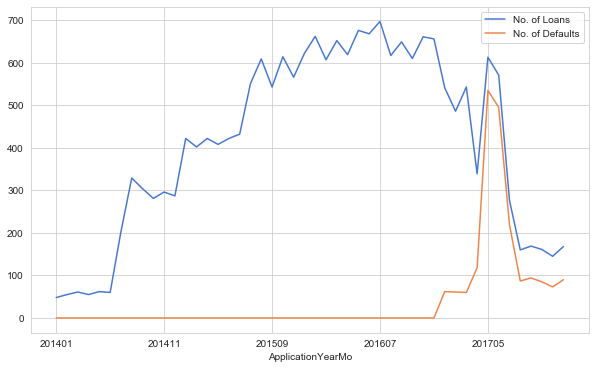

In [10]:
df['ApplicationYearMo'] = df.ApplicationDate.dt.year.apply(str) \
    + df.ApplicationDate.dt.month.apply(lambda x: '{:02d}'.format(x))

plt.figure(figsize=(10,6))
df.ApplicationYearMo.value_counts().sort_index().plot(label='No. of Loans')
df.groupby('ApplicationYearMo').Tagging.sum().plot(label='No. of Defaults')
plt.legend()

#### Check what type of cars might be driving this pattern


 First subplot: second-hand cars trend consistent with the pattern in [trend of defaults](#gg)

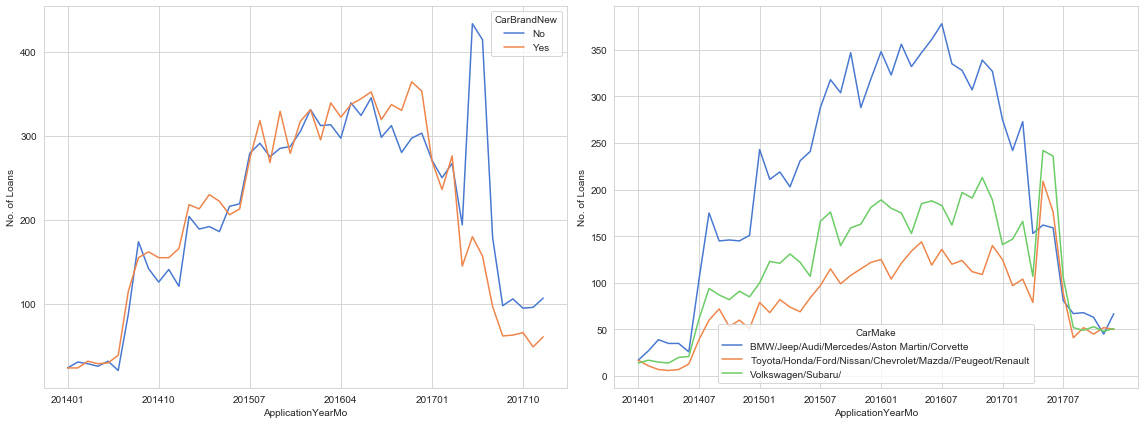

In [11]:
cols1 = ['ApplicationYearMo', 'CarBrandNew', 'No. of Loans']
df_1 = df.groupby(cols1[:-1]).size().to_frame(cols1[-1]).reset_index()
# df_1 = df_1.pivot(cols1[0], cols1[1], cols1[2])

cols2 = ['ApplicationYearMo', 'CarMake', 'No. of Loans']
df_2 = df.groupby(cols2[:-1]).size().to_frame(cols2[-1]).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(16,6))
sns.lineplot(data=df_1, x=cols1[0], y=cols1[-1], hue=cols1[1], ax=axs[0])
sns.lineplot(data=df_2, x=cols2[0], y=cols2[-1], hue=cols2[1], ax=axs[1])
x = axs[0].set_xticks(df_1[cols1[0]].iloc[::18])
x = axs[1].set_xticks(df_2[cols2[0]].iloc[::18])
plt.tight_layout()

In [12]:
# 74% of all defaults are second-hand cars
df.query('Tagging==1').CarBrandNew.value_counts()

No     1470
Yes     509
Name: CarBrandNew, dtype: int64

#### Looking even closer (weekly resolution, 2017 data only)

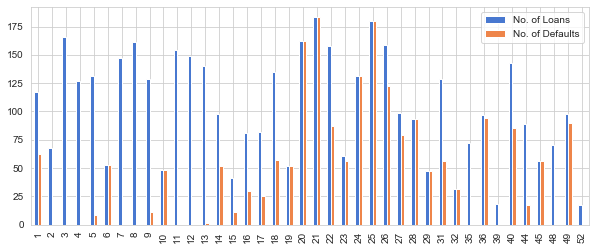

In [13]:
df_ =  df.query("ApplicationDate.dt.year >= 2017")
df_['ApplicationWeek'] = df_.ApplicationDate.dt.week
ax = df_.ApplicationWeek.value_counts().to_frame('No. of Loans') \
    .join(df_.groupby('ApplicationWeek').Tagging.sum().to_frame('No. of Defaults')) \
        .sort_index().plot(kind='bar', figsize=(10,4))

#### Check if data before 2017 overlaps with 2017 data.

Factor Analysis of Mixed Data (FAMD)  <br>

Guess: if they overlap (applicants have "similar" profiles), having a surge in loans/defaults in 2017 might be a discrepancy or caused by factors not captured by the data <br>
NOTE: 2 components only captured ~12.3% variance, not reliable

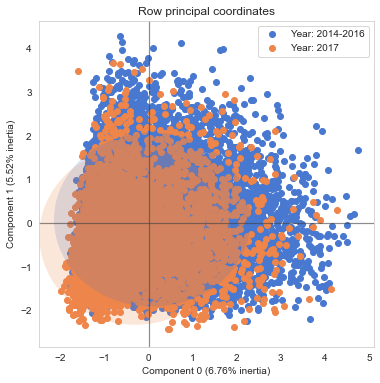

In [14]:
import prince

df_ = df[NUMERIC_COLS + NON_GRP_CAT_COLS]

FAMD = prince.FAMD(n_iter=10, random_state=1)
FAMD = FAMD.fit(df_)

labels = df.ApplicationDate.apply(
    lambda x: 'Year: 2017' if x.year==2017 else 'Year: 2014-2016')

ax = FAMD.plot_row_coordinates(
    df_, ax=None, figsize=(6, 6), x_component=0, y_component=1,
    color_labels=labels, ellipse_outline=False,
    ellipse_fill=True, show_points=True)

## Explore Categorical Features

In [15]:
df_ = df[NON_GRP_CAT_COLS].apply(set).to_frame('Categories')
df_['CategoriesCount']  = df_.Categories.apply(len)
df_

,Categories,CategoriesCount
Channel,"{Branch, Dealer}",2
ExistingClient,"{Yes, No}",2
Sex,"{Male, Female}",2
CivilStatus,"{DeFacto Partnership, Married, Separated/Divor...",4
Education,"{Primary, Secondary, College, PhD/Masters, Som...",5
ZipCode,"{Good, Bad, Very Good, Fair}",4
HousingType,"{Rented, Owned, Mortgaged, Living with Parents...",4
DepositorTag,"{Yes, No}",2
EmploymentType,"{Employed, Self-Employed, Retired, None}",4
WorkStatus,"{Others, Consultant, Permanent/Regular, Probat...",6


### Distribution of Loans among Groups in Each Feature

It seems that:
1. Most features are evenly distributed among groups
2. More than 60% of applicants are employed, around 80% applied through Branch, more than 70% are existing clients

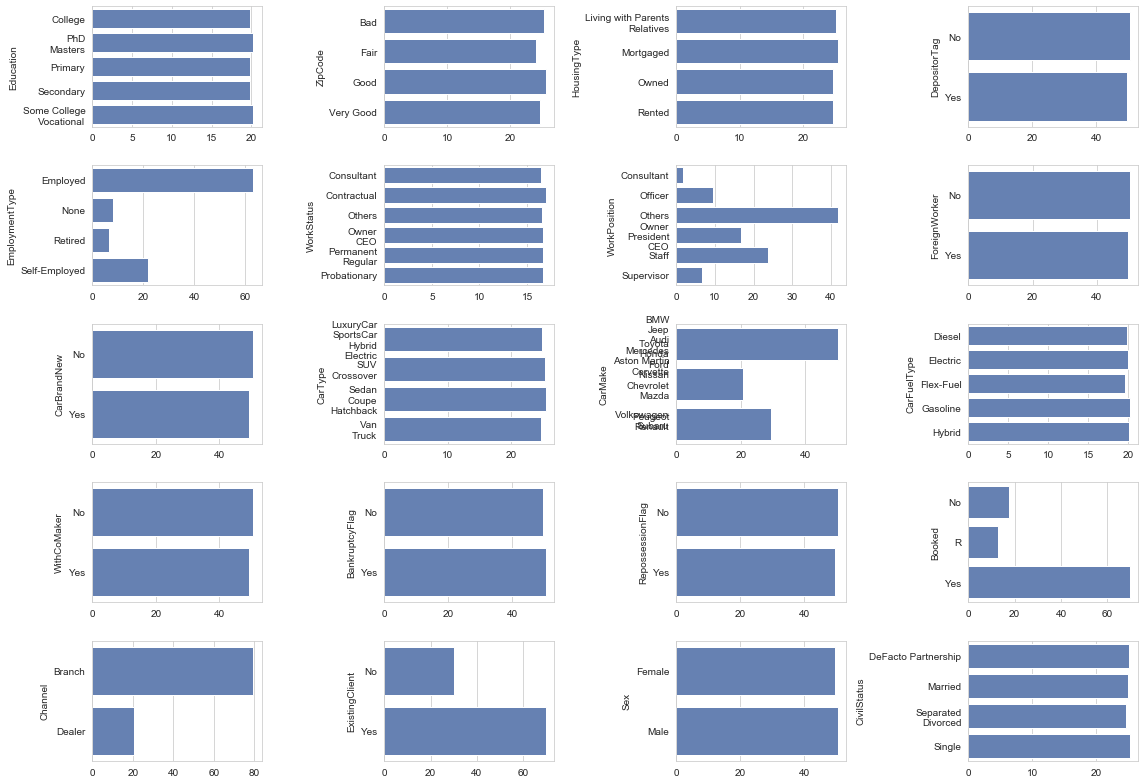

In [16]:
df_ = df.copy()
fig, axs = plt.subplots(5, 4, figsize=(16,11))
for i,c in enumerate(NON_GRP_CAT_COLS):
    ax = axs[int(i/4)-1,i%4]
    # df__ = df_.groupby(c).size() -- counts
    df__ = 100 * df_.groupby(c).size() / len(df_)
    sns.barplot(x=df__.values, y=df__.index, ax=ax, color=CLR)
    ax.set_yticklabels([x.replace('/', '\n') for x in list(df__.index)])
fig.tight_layout()

### Distribution of Defaults among Groups in Each Feature

NOTE: plots are as percentage of total applicants in each group

It seems that:
1. More than 20% of applicants in bad Zipcode defaulted compared to only around 5% for those in very good ZipCode
2. Looking at HousingType, applicants who owns a house (~25% of all loans) have the lowest default rate (<5%)
3. Looking at EmploymentType, self-employed applicants have the lowest default rate
4. Brand new cars, applicants with co-makers, those who applied through a Branch, Existing clients (~70% of all loans), bank depositors <br> have lower default rates than their counterparts
5. Men have higher default rate than women
6. Looking at CivilStatus, married applicants have the lowest default rate
7. BankruptcyFlag / RepossessionFlag = No, more likely to default?

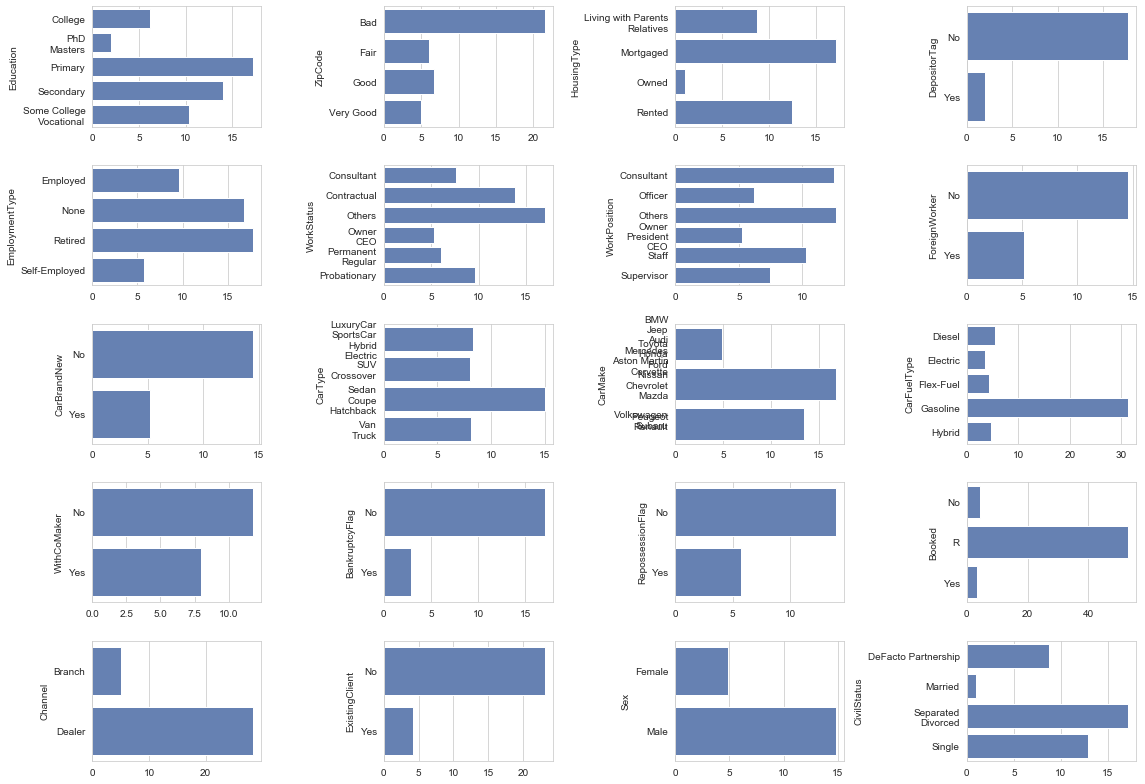

In [17]:
df_ = df.query('Tagging == 1')
fig, axs = plt.subplots(5, 4, figsize=(16,11))
for i,c in enumerate(NON_GRP_CAT_COLS):
    ax = axs[int(i/4)-1,i%4]
    # df__ = df_.groupby(c).size() -- counts
    df__ = 100 * df_.groupby(c).size() / df.groupby(c).size()
    sns.barplot(x=df__.values, y=df__.index, ax=ax, color=CLR)
    ax.set_yticklabels([x.replace('/', '\n') for x in list(df__.index)])
fig.tight_layout()

### Measure Strength of Association of each Feature with Target Variable

Cramer's V; Rule of thumb for strength of association --
Deg. of freedom = 1; > 0.1 - Weak, > 0.3 - Medium, > 0.5 - Strong

- It seems that `Booked` has strong association with the target variable, `CarFuelType` and `Channel` have medium association and the rest have weak association.

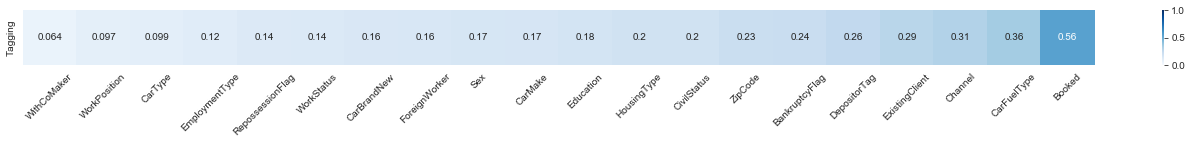

In [18]:
cv_corr = []
for c in NON_GRP_CAT_COLS:
    cv_corr.append(utils.cramers_corrected_stat(pd.crosstab(df[c], df[TARGET_COL])))
fig = plt.figure(figsize=(24,1))
ax = sns.heatmap(
    pd.DataFrame(cv_corr, index=NON_GRP_CAT_COLS, columns=[TARGET_COL]).sort_values(by=TARGET_COL).T, 
    vmin=0, vmax=1, annot=True, cbar=True, cmap=PLT)
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

DROP_COLS_CANDIDATES.update(['Booked'])

### Measure Strength of Association among Features

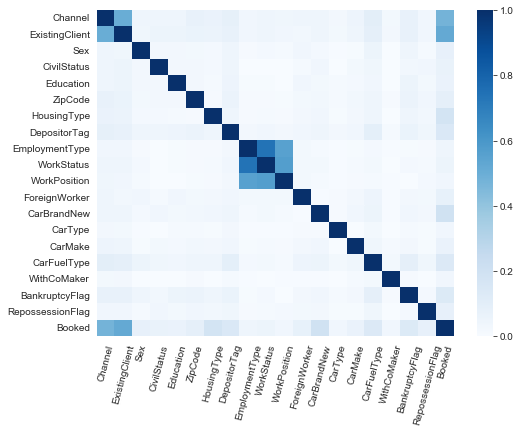

In [19]:
cv_corr = []
for c1 in NON_GRP_CAT_COLS:
    corr = []
    for c2 in NON_GRP_CAT_COLS:
        corr.append(utils.cramers_corrected_stat(pd.crosstab(df[c1], df[c2])))
    cv_corr.append(corr)

df_ = pd.DataFrame(cv_corr, index=NON_GRP_CAT_COLS, columns=NON_GRP_CAT_COLS)
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(df_, vmin=0, vmax=1,cbar=True, cmap=PLT)
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)

- The strong associations between pairs of features seem to make sense

In [20]:
df_ = utils.get_trunc_corr_df(df_, 0.5)

# Candidates for dropping due to strong association/dependence
# Check model if this needs to be met
# Drop those with weaker association with TARGET_COL
DROP_COLS_CANDIDATES.update(['EmploymentType', 'WorkPosition'])

df_

,ExistingClient,WorkStatus,WorkPosition,Booked
Channel,0.50592,NaN,NaN,NaN
ExistingClient,NaN,NaN,NaN,0.522417
EmploymentType,NaN,0.740993,0.557531,NaN
WorkStatus,NaN,NaN,0.572264,NaN


#### For Grouped Features

In [21]:
cv_corr = []
for c in GRP_CAT_COLS:
    cv_corr.append(utils.cramers_corrected_stat(pd.crosstab(df[c], df[TARGET_COL])))
pd.DataFrame(cv_corr, index=GRP_CAT_COLS, columns=[TARGET_COL]).sort_values(by=TARGET_COL).T

,NoOfOpenTradelinesInLast24Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast24Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast12Mos_grp,AgeofOldestTrades_grp,NoOfTradelinesWithMoreThan90DPDInLast9Mos_grp,NoOfOpenTradelinesInLast12Mos_grp,YrsinResidence_grp,YrsinEmploymentBusiness_grp,NoOfOpenTradelinesInLast9Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast6Mos_grp,AverageAgeofTrades_grp,RequestedLoanAmount_grp,Age_grp,DTIRatio_grp,NoOfOpenTradelinesInLast6Mos_grp,RepaymentAmount_grp,NoOfTradelinesWithMoreThan90DPDInLast3Mos_grp,CarAppraisalValue_grp,InterestRatePct_grp,NetIncome_grp,NoOfOpenTradelinesInLast3Mos_grp,NumberofDependents_grp,CarAge_grp,MonthlyExpenses_grp,NoOfExistingLoans_grp,CarMileage_grp,MonthlyIncome_grp
Tagging,0.014155,0.014456,0.021468,0.036276,0.036403,0.036734,0.042184,0.051253,0.069087,0.073164,0.088774,0.090587,0.09619,0.103465,0.119073,0.130246,0.153393,0.15581,0.157754,0.164381,0.17108,0.17158,0.187415,0.195582,0.325533,0.336432,0.340715


- It seems that the strong associations between pairs of features makes sense e.g. CarAge_grp - CarMileage_grp

In [22]:
cv_corr = []
for c1 in GRP_CAT_COLS:
    corr = []
    for c2 in GRP_CAT_COLS:
        corr.append(utils.cramers_corrected_stat(pd.crosstab(df[c1], df[c2])))
    cv_corr.append(corr)

df_ = pd.DataFrame(cv_corr, index=GRP_CAT_COLS, columns=GRP_CAT_COLS)
df_ = utils.get_trunc_corr_df(df_, 0.5)

# NOTE: No strong association between features from NON_GRP_CAT_COLS and from GRP_CAT_COLS
DROP_COLS_CANDIDATES.update(['RequestedLoanAmount_grp', 'MonthlyExpenses_grp', 'CarAge_grp'])

df_

,RequestedLoanAmount_grp,CarMileage_grp,MonthlyIncome_grp
RepaymentAmount_grp,0.582295,NaN,NaN
CarAge_grp,NaN,0.500695,NaN
CarAppraisalValue_grp,0.515057,NaN,NaN
MonthlyExpenses_grp,NaN,NaN,0.553793


## Explore Numerical Features

### Distribution of Loans per Feature

- DTIRatio > 1 ? According to [this](https://www.thecarconnection.com/car-loans/finance-guides/do-you-have-enough-available-income-to-qualify-for-a-car-loan/#:~:text=Lenders%20use%20this%20to%20determine,estimated%20vehicle%20and%20insurance%20payment.) lenders generally require that DTI ratio be no more than 45% to 50% 
    - they probably borrowed against a high value asset or they have co-makers?
    - probably why DTIRatio_grp has [0.4,10] as last bucket
- Many features are skewed to the right; Transform (?)

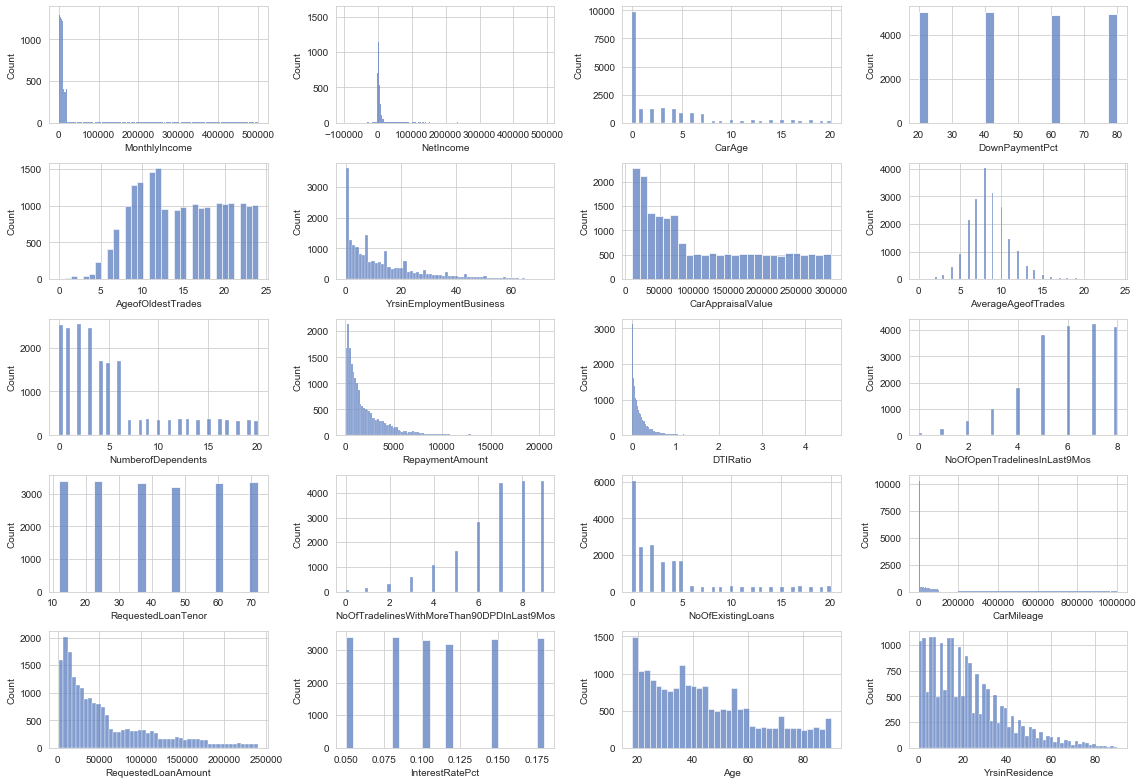

In [23]:
cols = list(set(NUMERIC_COLS) - set(['MonthlyExpenses'] \
    + [x for x in NUMERIC_COLS if 'Tradelines' in x and '9Mos' not in x]))
fig, axs = plt.subplots(5, 4, figsize=(16,11))
for i,c in enumerate(cols):
    ax = axs[int(i/4)-1,i%4]
    sns.histplot(x=c, data=df, ax=ax, color=CLR)
plt.tight_layout()

In [24]:
print(100*(df.DTIRatio >= 1).sum() / len(df),'%')
print(df.DTIRatio_grp.unique())

3.29 %
['(0,0.03]' '(0.1,0.2]' '(0.03,0.1]' '(0.2,0.4]' '(0.4,10]']


### Distribution of Loans per Feature per Target class

It seems that:
1. Applicants who put in a higher downpayment have less defaults
2. Younger applicants, applicants with lesser no. of dependents have less defaults
4. YrsinResidence, NoOfTradelines between those who defaulted vs those who did not have no difference
5. Older cars are more likely to be defaulted

TODO: How to deal with outliers? OR use grouped features, any reason why nobody is earning <1,000 or >500,000?

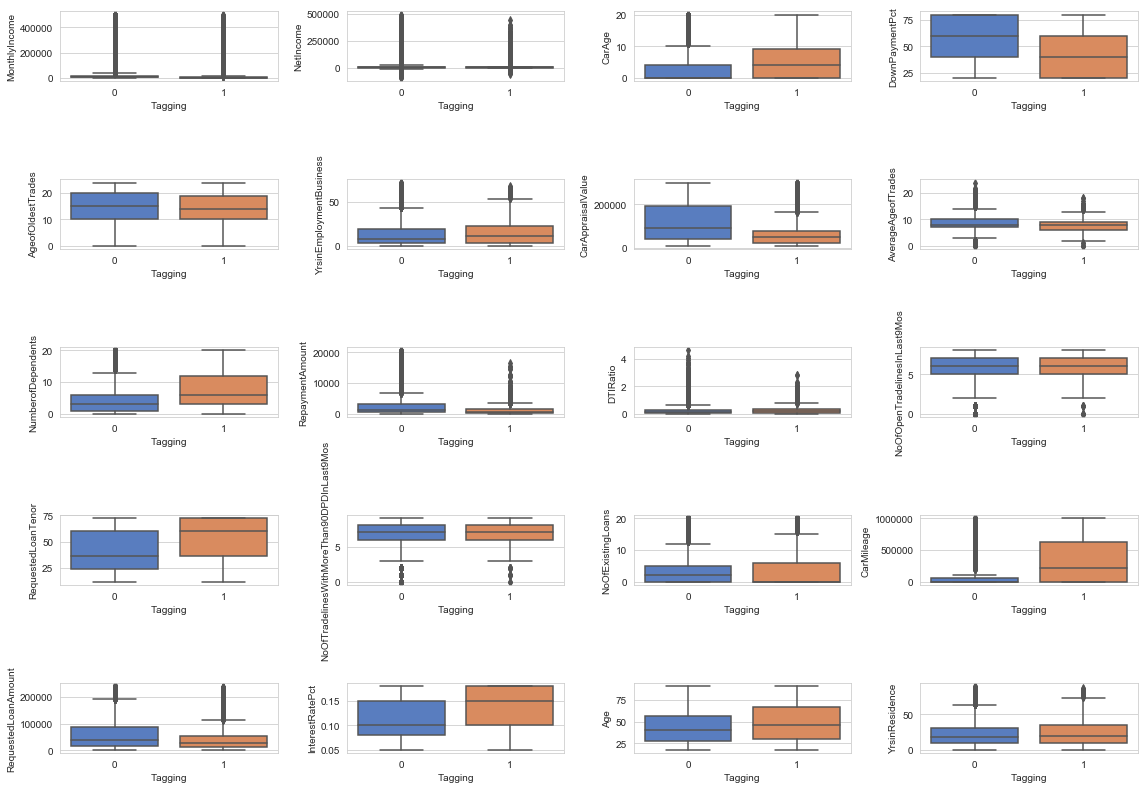

In [25]:
fig, axs = plt.subplots(5, 4, figsize=(16,11))
for i,c in enumerate(cols):
    ax = axs[int(i/4)-1,i%4]
    sns.boxplot(y=c, x=TARGET_COL, data=df, ax=ax)
plt.tight_layout()

### Measure Strength of Association with Target Variable

In [26]:
# TODO:  Rank-Biserial Correlation(?); no python implementation

### Measure Strength of Association among Features

Spearman correlation; rule of thumb - rho > 0.7 as highly correlated

,YrsinEmploymentBusiness,MonthlyExpenses,CarAge,RequestedLoanAmount,RepaymentAmount,InterestRatePct,NoOfOpenTradelinesInLast6Mos
Age,0.723671,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyIncome,NaN,0.799916,NaN,NaN,NaN,NaN,NaN
CarAppraisalValue,NaN,NaN,NaN,0.872938,0.80481,NaN,NaN
CarMileage,NaN,NaN,0.857684,NaN,NaN,NaN,NaN
RequestedLoanAmount,NaN,NaN,NaN,NaN,0.91808,NaN,NaN
RequestedLoanTenor,NaN,NaN,NaN,NaN,NaN,1.0,NaN
NoOfOpenTradelinesInLast3Mos,NaN,NaN,NaN,NaN,NaN,NaN,0.703715


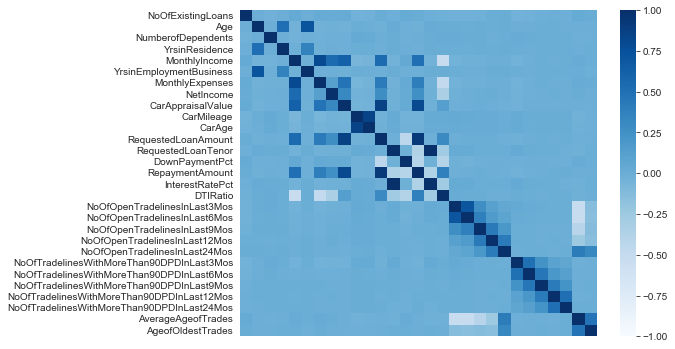

In [27]:
fig = plt.figure(figsize=(8,6))
df_ = df[NUMERIC_COLS].corr(method='spearman')
ax = sns.heatmap(df_, vmin=-1, vmax=1, cbar=True, cmap=PLT)
x = ax.set_xticklabels([], rotation=75)

df_ = utils.get_trunc_corr_df(df_, 0.7)
df_

In [28]:
DROP_COLS_CANDIDATES.update(['YrsinEmploymentBusiness', 'MonthlyExpenses', 'CarAge', 
    'CarAppraisalValue', 'RequestedLoanAmount', 
    'InterestRatePct', 'NoOfOpenTradelinesInLast3Mos'])

# rho=1, Interest fixed given duration of loan tenor
df[['RequestedLoanTenor', 'InterestRatePct']].sort_values('InterestRatePct').drop_duplicates()

,RequestedLoanTenor,InterestRatePct
AccountNo,,
16995,12,0.05
11224,24,0.08
6936,36,0.10
11686,48,0.12
8773,60,0.15
4064,72,0.18


## Misc.

### Quick Stats

 > Bank XYZ had a total of 20,000 loan applications from January 8, 2014 to December 7, 2017. <br>
The median DTI ratio of these loans were 12.4%. <br>
80% of these loans were made through a branch and 20% through a dealer. <br>
50% of cars loaned were brandnew and 50% were second-hand. <br>
These loans were also evenly split, i.e. ~50-50 split, between genders and foreign and local borrowers . <br>
Mean age and median monthly income of applicants were 44 years and ~P8,500 respectively.

In [29]:
display(df.MonthlyIncome.agg(['min', 'median', 'max']))
display(df.DTIRatio.agg(['min', 'median', 'max']))
display(df.Age.agg(['min', 'mean', 'max']))

min         1000.0
median      8443.5
max       499992.0
Name: MonthlyIncome, dtype: float64

min       0.000302
median    0.124134
max       4.584970
Name: DTIRatio, dtype: float64

min     18.0000
mean    44.0583
max     90.0000
Name: Age, dtype: float64

In [30]:
def gg(df, c):
    df_ = df[c].value_counts()
    return df_.to_frame(c+'_count').join(df_.to_frame('pct')/20000)

cols = ['HousingType', 'Sex', 'Channel', 'ForeignWorker', 'CarBrandNew']
for c in cols:
    display(gg(df,c))

,HousingType_count,pct
Mortgaged,5083,0.25415
Living with Parents/Relatives,5036,0.25180
Owned,4946,0.24730
Rented,4935,0.24675


,Sex_count,pct
Male,10069,0.50345
Female,9931,0.49655


,Channel_count,pct
Branch,15909,0.79545
Dealer,4091,0.20455


,ForeignWorker_count,pct
No,10040,0.502
Yes,9960,0.498


,CarBrandNew_count,pct
No,10144,0.5072
Yes,9856,0.4928


Existing clients comprised 70% of all loans and are less likely to default. <br>
They also request for shorter tenor which is indicative of lower risk (?); faster cashflow

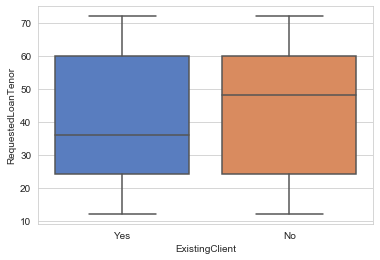

In [31]:
ax = sns.boxplot(data=df, y='RequestedLoanTenor', x='ExistingClient')

In [32]:
# df_ = df[df.NetIncome < 0] # 3311/20000 (16.6%)
# df_test.Channel.value_counts() # 77.8% via Branch
# df_test.ExistingClient.value_counts() # 69.7% existing client
# df_test.Tagging.value_counts() # 10.9% default

#### Save data and etc

In [33]:
import pickle

d = {'NON_GRP_CAT_COLS': NON_GRP_CAT_COLS, 
    'NUMERIC_COLS': NUMERIC_COLS, 
    'GRP_CAT_COLS': GRP_CAT_COLS, 
    'DROP_COLS_CANDIDATES': DROP_COLS_CANDIDATES,
    'TARGET_COL':TARGET_COL,
    'CLR':'#597dbf',
    'PLT':'Blues'}

with open('feature_groups.pkl', 'wb') as f:
    pickle.dump(d, f)

with open('car_data.pkl', 'wb') as f:
    pickle.dump(df.drop('ApplicationYearMo', axis=1), f)

DROP_COLS_CANDIDATES

{'Booked',
 'CarAge',
 'CarAge_grp',
 'CarAppraisalValue',
 'EmploymentType',
 'InterestRatePct',
 'MonthlyExpenses',
 'MonthlyExpenses_grp',
 'NoOfOpenTradelinesInLast3Mos',
 'RequestedLoanAmount',
 'RequestedLoanAmount_grp',
 'WorkPosition',
 'YrsinEmploymentBusiness'}

# Key Takeaways, Recommendations and Next Steps


- Bank XYZ had a total of 20,000 loan applications from January 8, 2014 to December 7, 2017.  The median DTI ratio of all the loans is 12.4% which is well below the 45-50% level that lenders usually require. 80% of these loans were made through a branch while 20% through a dealer. The mean age and median monthly income of applicants were 44 years and ~P8,500 respectively.   
- The number of loans increased by 194.6% in 2015 and 29.3% in 2016, but dropped by 46.3% in 2017. There were no defaults from 2014-2016 but in 2017, there were 1979 defaults which accounts for 47.4% of all loans during that year. While Bank XYZ seems to be above the trend from 2015-2016 looking at vehicle sales growth in the PH, it is below the trend in 2017 since vehicle sales in PH actually grew by 19.6% in that year. Loan defaults were primarily from seconhand car loans which represents 74% of all defaults.
- Who defautls less?
    - 70% of loan applications were from existing clients. Default rate for this group is less than 5% compared to around 25% for non existing clients. Faster cashflow can also be expected from existing clients since their median requested tenor is 36 months compared to 48 months for their counterpart. Similar thing can be said for existing depositor (73% of existing clients)
    - Applicants who owns a house, those who are married, and those with co-makers are less likey to default than thier counterparts
    - Those who are applying for a brandnew car loan and those who applied through a branch are also less likey to default than thier counterparts


TODO:
- Look for Rank-Biserial Correlation python implementation or try in R/SAS (?)